In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from dbhelper import pd_query
from BorderModel import BorderData, clean_df_subset
import datetime

In [26]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday
        from datefeatures d 
        left join crossingdata c
        on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = 1
        order by c.date
        '''

df = pd_query(query)

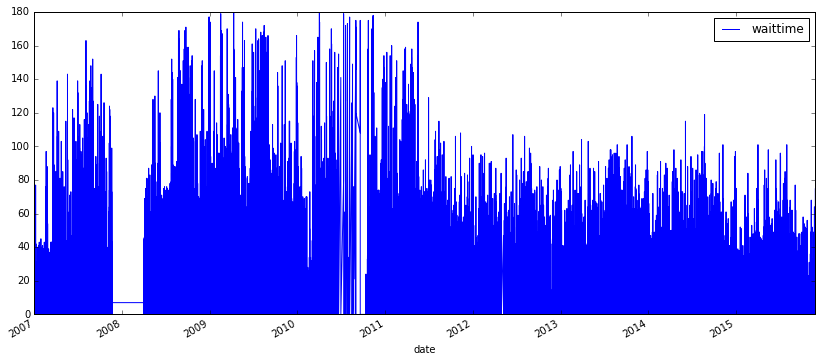

In [7]:
dfwt = df[['date', 'waittime']].set_index('date')
dfwt.plot(figsize=(14,6));

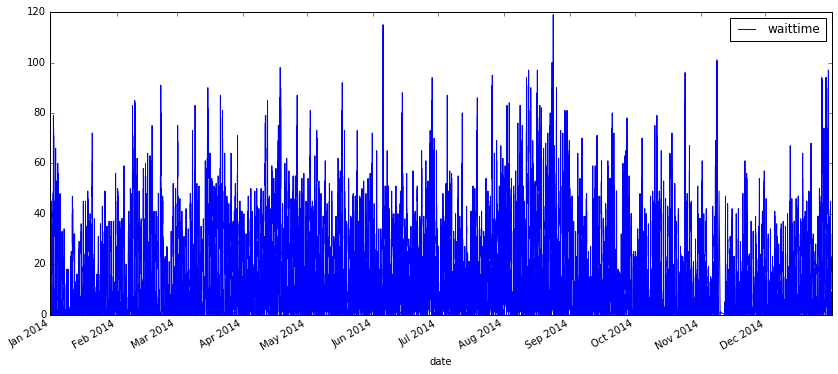

In [27]:
dfyear = df[(df.year==2014)][['date', 'waittime']].set_index('date')
dfyear.plot(figsize=(14,6));

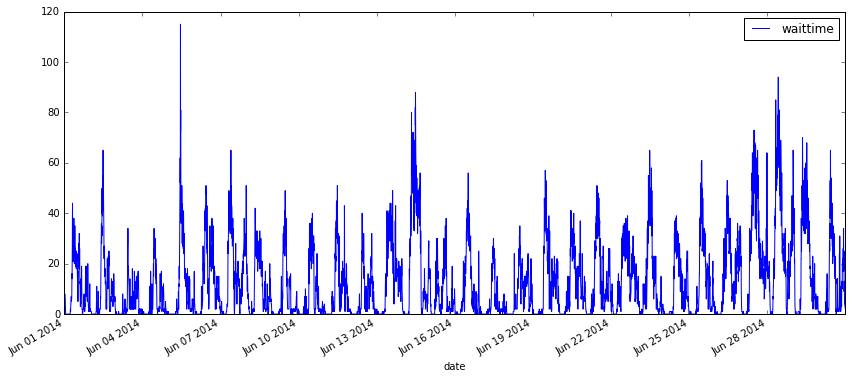

In [28]:
dfmonth = df[(df.year==2014) & (df.month==6)][['date', 'waittime']].set_index('date')
dfmonth.plot(figsize=(14,6));

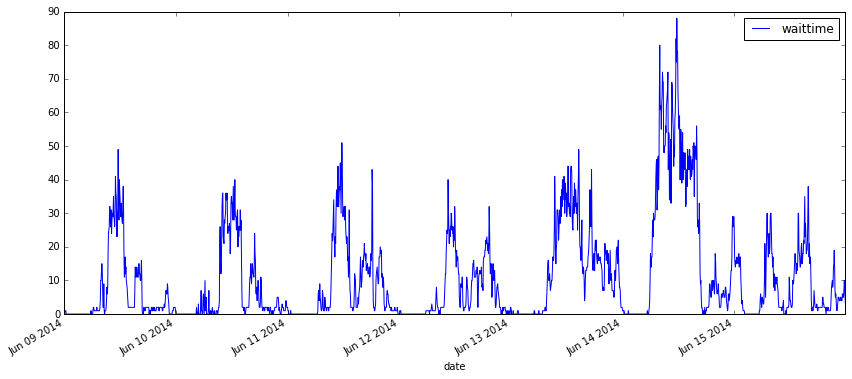

In [104]:
dfweek = df[(df.year==2014) & (df.week==24)][['date', 'waittime', 'dayofweek']].set_index('date')
dfweek[['waittime']].plot(figsize=(14,6));

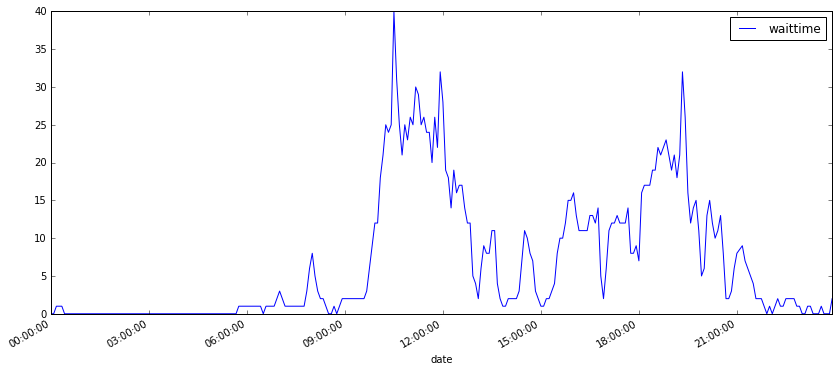

In [30]:
dfday = df[(df.year==2014) & (df.month==6) & (df.dayofmonth==12)][['date', 'waittime']].set_index('date')
dfday.plot(figsize=(14,6));

## Apply smoothing to daily data

In [34]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

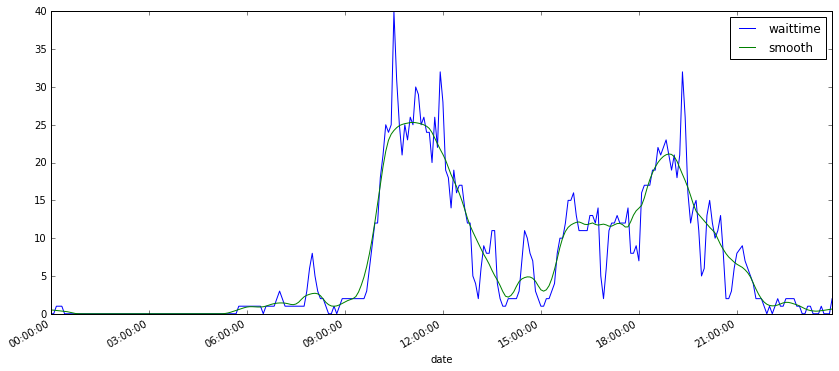

In [129]:
z = lowess(dfday.waittime, dfday.index, frac=.05, it=1)
dfday['smooth'] = z[:,1]
dfday.plot(figsize=(14,6));

## Apply smoothing to weekly data

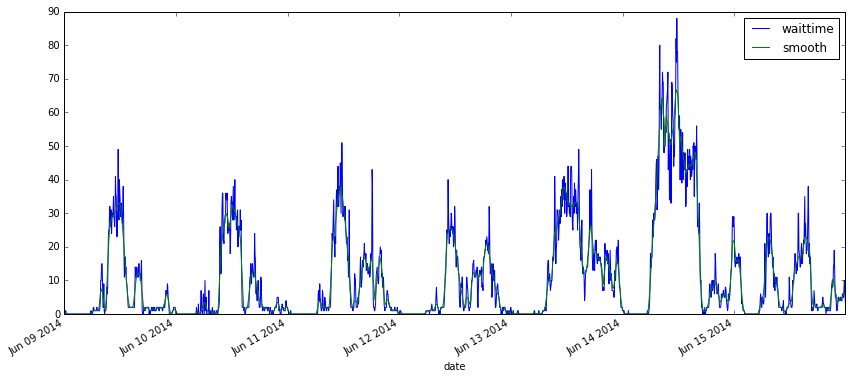

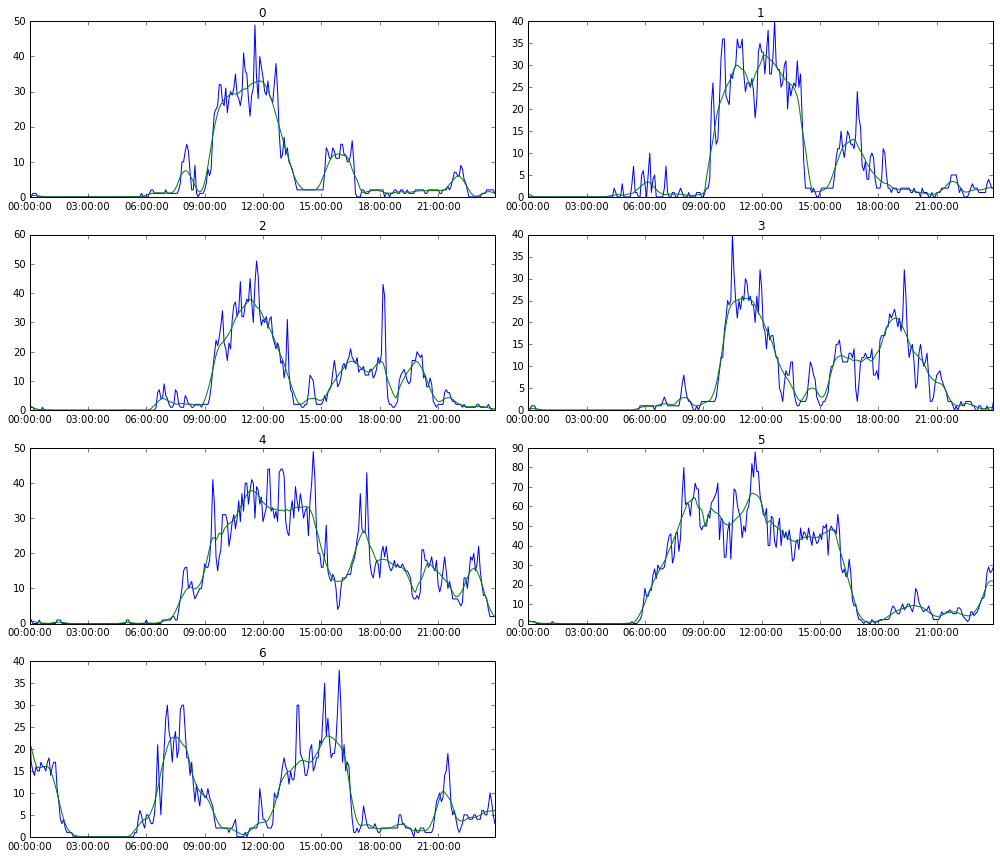

In [130]:
z = lowess(dfweek.waittime, dfweek.index, frac=.05/7, it=1)
dfweek['smooth'] = z[:,1]
dfweek[['waittime', 'smooth']].plot(figsize=(14,6));

plt.figure(figsize=(14,12))
for day in range(7):
    plt.subplot(4, 2, day+1)
    plt.title(day)
    plt.plot(dfweek[dfweek.dayofweek==day][['waittime', 'smooth']])
plt.tight_layout()
plt.show()

## How does smoothing work for missing data?

In [213]:
query = '''
        select 
            d.date,
            case when valid=1 then waittime else null end as waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday
        from datefeatures d 
        left join crossingdata c
        on c.date = d.date
        where
            crossing_id = 1
        order by d.date
        '''

df1 = pd_query(query)

In [214]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937441 entries, 0 to 937440
Data columns (total 8 columns):
date          937441 non-null datetime64[ns]
waittime      829171 non-null float64
year          937441 non-null int64
month         937441 non-null int64
dayofmonth    937441 non-null int64
week          937441 non-null int64
dayofweek     937441 non-null int64
minofday      937441 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 64.4 MB


In [208]:
df1[(pd.isnull(df1.waittime)) & (df1.year==2014) &(df1.week==3)]

,date,waittime,year,month,dayofmonth,week,dayofweek,minofday
740023,2014-01-13 12:35:00,NaN,2014,1,13,3,0,755
740118,2014-01-13 20:30:00,NaN,2014,1,13,3,0,1230
740311,2014-01-14 12:35:00,NaN,2014,1,14,3,1,755
740487,2014-01-15 03:15:00,NaN,2014,1,15,3,2,195
740488,2014-01-15 03:20:00,NaN,2014,1,15,3,2,200
741812,2014-01-19 17:40:00,NaN,2014,1,19,3,6,1060
741813,2014-01-19 17:45:00,NaN,2014,1,19,3,6,1065


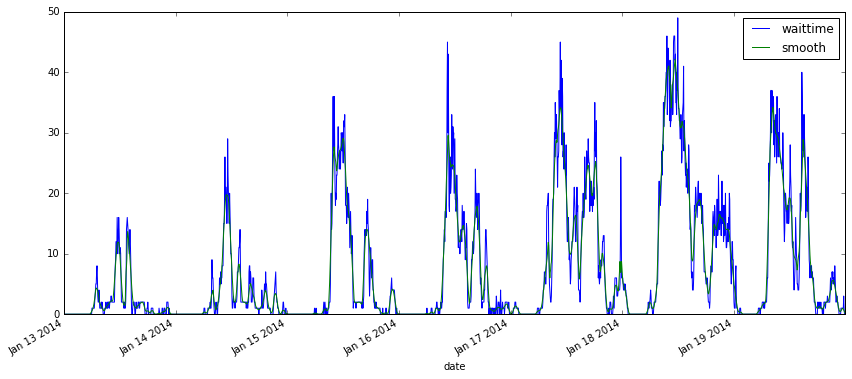

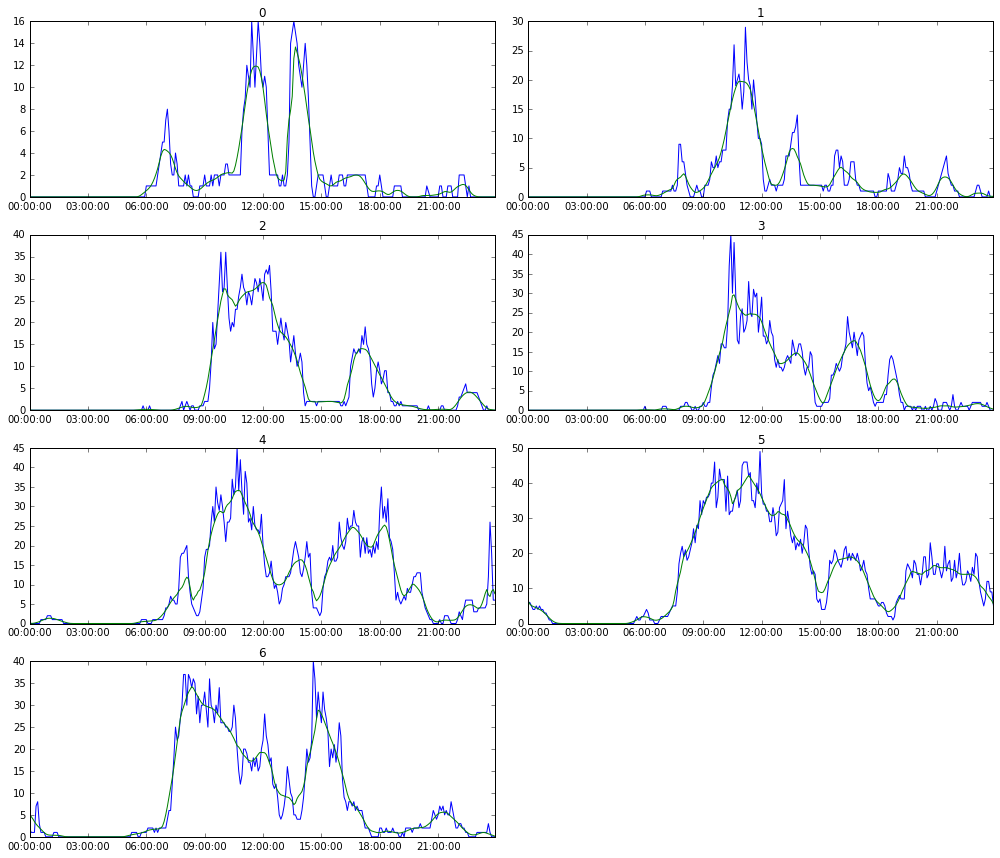

In [223]:
dfweek1 = df[(df.year==2014) & (df.week==3)][['date', 'waittime', 'dayofweek']].set_index('date')

z = lowess(dfweek1.waittime, dfweek1.index, frac=.05/7, it=1)
dfweek1['smooth'] = z[:,1]
dfweek1[['waittime', 'smooth']].plot(figsize=(14,6));

plt.figure(figsize=(14,12))
for day in range(7):
    plt.subplot(4, 2, day+1)
    plt.title(day)
    plt.plot(dfweek1[dfweek1.dayofweek==day][['waittime', 'smooth']])
plt.tight_layout()
plt.show()

## For small null gaps, smoothing works well.  Investigate larger gaps.

In [155]:
df1[(pd.isnull(df1.waittime)) & (df1.year==2014)].groupby('week').count()

,date,waittime,year,month,dayofmonth,dayofweek,minofday
week,,,,,,,
1,9,0,9,9,9,9,9
2,14,0,14,14,14,14,14
3,7,0,7,7,7,7,7
4,8,0,8,8,8,8,8
5,20,0,20,20,20,20,20
6,23,0,23,23,23,23,23
7,11,0,11,11,11,11,11
8,13,0,13,13,13,13,13
9,6,0,6,6,6,6,6


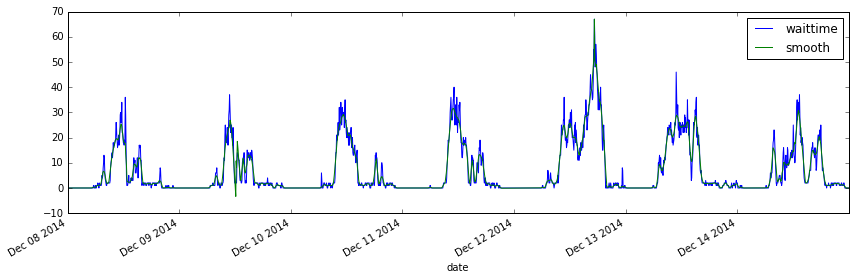

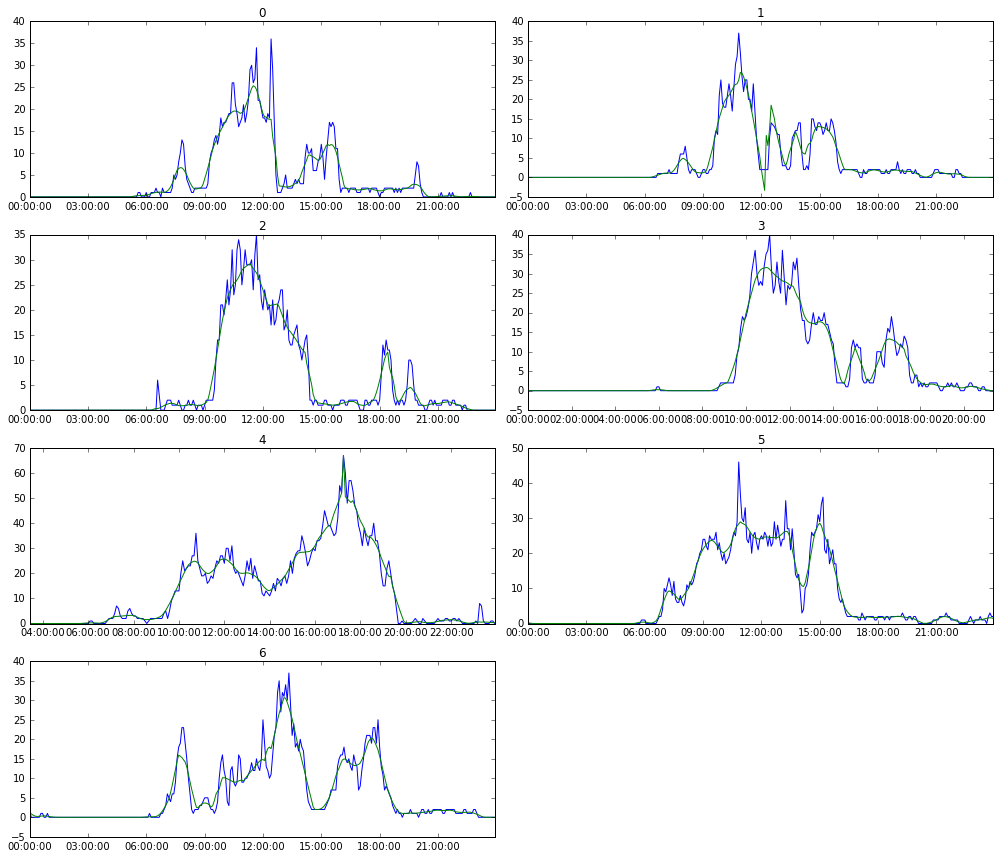

In [175]:
dfweek1 = df[(df.year==2014) & (df.week==50)][['date', 'waittime', 'dayofweek']].set_index('date')

z = lowess(dfweek1.waittime, dfweek1.index, frac=.05/7, it=1)
dfweek1['smooth'] = z[:,1]
dfweek1[['waittime', 'smooth']].plot(figsize=(14,4));

plt.figure(figsize=(14,12))
for day in range(7):
    plt.subplot(4, 2, day+1)
    plt.title(day)
    plt.plot(dfweek1[dfweek1.dayofweek==day][['waittime', 'smooth']])
plt.tight_layout()
plt.show()

## Impact of null counts depend on when they occur.  Before 6AM, there is not much effect.

## Focus on days with high number of null counts to determine the threshold of null counts where data cannot be smoothed well. 

In [204]:
query = '''
        select 
            d.date::timestamp::date,
            sum( case when waittime is null then 1 else 0 end ) as ct_wt
        from datefeatures d 
        left join crossingdata c
        on c.date = d.date
        where
            crossing_id = 1
            and hour >= 6
        group by d.date::timestamp::date
        order by d.date::timestamp::date;
        '''

dfnullcount = pd_query(query)

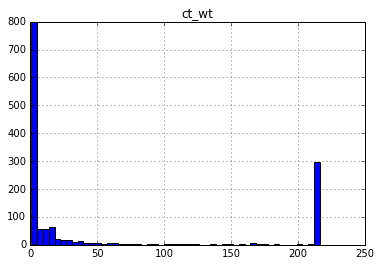

In [205]:
dfnullcount[dfnullcount.ct_wt > 0].hist(bins=50);

In [187]:
dfnullcount[dfnullcount.ct_wt > 100].sort_values('ct_wt').head()

,date,ct_wt
1557,2011-04-07,101
1387,2010-10-19,101
504,2008-05-19,104
2023,2012-07-16,105
598,2008-08-21,105


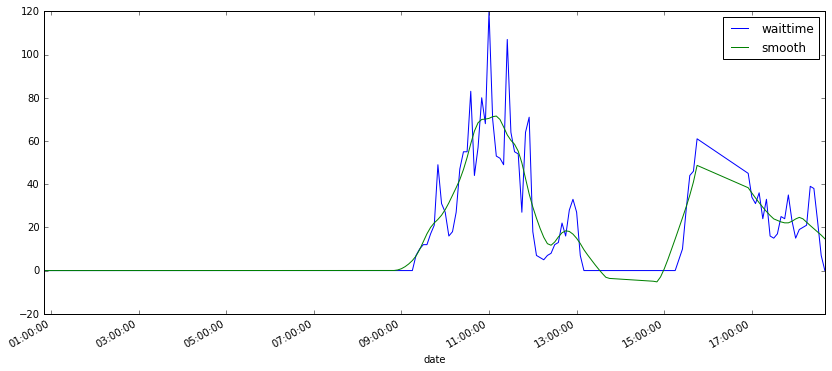

In [225]:
dfday1 = df[(df.year==2011) & (df.month==4) & (df.dayofmonth==7)][['date', 'waittime']].set_index('date')
z = lowess(dfday1.waittime, dfday1.index, frac=.09, it=0)
dfday1['smooth'] = z[:,1]
dfday1.plot(figsize=(14,6));

### Nulls were handled, but smoothing fraction needs to be adjusted because there is less data.  Remaining data is a larger proportion of remaining data.

### Need to run smoothing on each day independently.

In [220]:
df1[df1.date>'2011-04-07 13:00'].head(20)

,date,waittime,year,month,dayofmonth,week,dayofweek,minofday
448573,2011-04-07 13:05:00,7,2011,4,7,14,3,785
448574,2011-04-07 13:10:00,0,2011,4,7,14,3,790
448575,2011-04-07 13:15:00,0,2011,4,7,14,3,795
448576,2011-04-07 13:20:00,0,2011,4,7,14,3,800
448577,2011-04-07 13:25:00,0,2011,4,7,14,3,805
448578,2011-04-07 13:30:00,0,2011,4,7,14,3,810
448579,2011-04-07 13:35:00,0,2011,4,7,14,3,815
448580,2011-04-07 13:40:00,0,2011,4,7,14,3,820
448581,2011-04-07 13:45:00,0,2011,4,7,14,3,825
448582,2011-04-07 13:50:00,NaN,2011,4,7,14,3,830
